<a href="https://colab.research.google.com/github/JosegSuarezb/aprendizaje-no-supervisado-2/blob/main/Parcial1_JoseGregorio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

En el mercado inmobiliario de Nueva York, la diversidad de propiedades disponibles presenta
un desafío para los agentes inmobiliarios al momento de especializarse y maximizar sus
ventas. La venta de una casa costosa con pocas habitaciones difiere significativamente de
una casa económica con múltiples habitaciones, lo que resalta la importancia de la
especialización.
La empresa esta interesada en crear grupos de casas basados en el precio, tamaño, precio
por metro cuadrado, número de habitaciones y baños, tipo de casa y ubicación.
Para este parcial se consideran los datos de NY-House-Dataset.csv que se encuentra en el
módulo de bases de datos y solo se va a trabajar con las siguientes variables:
• TYPE: Type of the house.
• PRICE: Price of the house.
• BEDS: Number of bedrooms.
• BATH: Number of bathrooms.
• PROPERTYSQFT: Square footage of the property.
• LATITUDE: Latitude coordinate of the house.
• LONGITUDE: Longitude coordinate of the house.

In [ ]:
from google.colab import drive # conexión con drive
drive.mount('/content/drive')
import pandas as pd # Manejo de Data Frame
import numpy as np # Manejo matricial
import warnings # Omitir warnings
warnings.filterwarnings("ignore") # Ignorar warning (me estresan los warnings >:|)
# librerías para Gráficos
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
# Librerías para clustering
from sklearn.cluster import (KMeans, AgglomerativeClustering)
from scipy.cluster.hierarchy import dendrogram,  linkage # Dendograma
# Score de silueta
from sklearn.metrics import silhouette_score, pairwise_distances_argmin_min
from sklearn.preprocessing import StandardScaler # estandarizar variables.

Mounted at /content/drive


In [ ]:
datos = pd.read_csv("/content/drive/MyDrive/aprendizaje no supervisado/NY-House-Dataset.csv")
datos= datos[ datos["PRICE"]< 10**7]
datos=datos[datos["BEDS"] <20]
datos=datos[datos["BATH"] <20]
datos["TYPE"]= datos["TYPE"].replace({"Condop for sale": "Condo for sale",
                                      'Multi-family home for sale': "House for sale",
                                      # "Townhouse for sale":"House for sale",
                                      'Pending':np.nan, 'Contingent':np.nan})
categorias_drop = [ 'Land for sale', 'For sale', "House for sale",
                   'Foreclosure', 'Coming Soon',
                   'Mobile house for sale',"Townhouse for sale"]
datos["TYPE"] = datos["TYPE"].replace( categorias_drop, "Other")
datos = datos[~datos["TYPE"].isin(categorias_drop)]

Entendimiento de los datos: ¿los datos tienen registros faltantes? Elimínelos si los tiene ¿cuántos datos quedan al final?

In [ ]:
datos.isna().sum()

,0
BROKERTITLE,0
TYPE,327
PRICE,0
BEDS,0
BATH,0
PROPERTYSQFT,0
ADDRESS,0
STATE,0
MAIN_ADDRESS,0
ADMINISTRATIVE_AREA_LEVEL_2,0


In [ ]:
datos=datos.dropna(subset=["TYPE"])
datos.isna().sum()

,0
BROKERTITLE,0
TYPE,0
PRICE,0
BEDS,0
BATH,0
PROPERTYSQFT,0
ADDRESS,0
STATE,0
MAIN_ADDRESS,0
ADMINISTRATIVE_AREA_LEVEL_2,0


Se identifico que la base de datos en la variable TYPE tenia 327 datos faltantes lo que la base de datos tenia 4628 datos pero luego de hacerle la limpieza esta base se redujo a 4301 datos

3. Crear las variables:
a. Precio por cada metro cuadrado.
b. Número total de habitaciones y baños.
Debe seleccionar las nuevas variables que creo y seleccionar TYPE, PRICE,PROPERTYSQFT, LATITUD, LONGITUD.


In [ ]:
PrecioxM2=datos["PRICE"]/datos["PROPERTYSQFT"]
datos["PrecioxM2"]=PrecioxM2
PrecioxM2

,0
0,225.000000
2,129.032258
3,155.056180
5,172.327672
6,411.819779
...,...
4796,274.241298
4797,112.168812
4798,583.735652
4799,913.167939


In [ ]:
NumTotalHaYBa=datos["BEDS"]+datos["BATH"]
datos["NumTotalHaYBA"]=NumTotalHaYBa
NumTotalHaYBa

,0
0,4.0
2,6.0
3,4.0
5,7.0
6,4.0
...,...
4796,2.0
4797,2.0
4798,2.0
4799,3.0


In [ ]:
VariablesInteres=datos[["TYPE","PRICE","PROPERTYSQFT","NumTotalHaYBA","PrecioxM2","LATITUDE","LONGITUDE"]]
VariablesInteres

,TYPE,PRICE,PROPERTYSQFT,NumTotalHaYBA,PrecioxM2,LATITUDE,LONGITUDE
0,Condo for sale,315000,1400.000000,4.0,225.000000,40.761255,-73.974483
2,Other,260000,2015.000000,6.0,129.032258,40.541805,-74.196109
3,Condo for sale,69000,445.000000,4.0,155.056180,40.761398,-73.974613
5,Other,690000,4004.000000,7.0,172.327672,40.674363,-73.958725
6,Condo for sale,899500,2184.207862,4.0,411.819779,40.809448,-73.946777
...,...,...,...,...,...,...,...
4796,Co-op for sale,599000,2184.207862,2.0,274.241298,40.774350,-73.955879
4797,Co-op for sale,245000,2184.207862,2.0,112.168812,40.732538,-73.860152
4798,Co-op for sale,1275000,2184.207862,2.0,583.735652,40.745882,-74.003398
4799,Condo for sale,598125,655.000000,3.0,913.167939,40.742770,-73.872752


De las variables seleccionadas, escoja solo 2 variables para realizar un análisis descriptivo, debe incluir un gráfico que involucre las dos variables o dos gráficos por cada variable. Debe realizar un análisis de las variables.


In [ ]:
px.box(datos, x='NumTotalHaYBA', y='PRICE',color="NumTotalHaYBA",
       points=False, # No muestra los puntos atípicos extendiendo las barras
             title='Price Vs Number of Bedrooms and Bathrooms')

De acuerdo con la grafica realizada se puede observar una tendencia no tan pronunciada pero si una tendencia positiva o de alza con respecto a la relacion entre precio y numero de habitaciones y baños por lo que se puede concluir que de acuerdo que aumenten los baños y las habitaciones de una casa va a aumentar su precio teniendo en cuenta la grafica.

Realice una transformación de variables categóricas a dummy y estandarizar las variables para aplicar los métodos de segmentación.

In [ ]:
#TRANSFORMACIÓN DE VARIABLES CATEGORICAS A DUMMY
datos_numericos=pd.get_dummies(VariablesInteres, columns=['TYPE'],dtype=int, drop_first=True )
datos_numericos

,PRICE,PROPERTYSQFT,NumTotalHaYBA,PrecioxM2,LATITUDE,LONGITUDE,TYPE_Condo for sale,TYPE_Other
0,315000,1400.000000,4.0,225.000000,40.761255,-73.974483,1,0
2,260000,2015.000000,6.0,129.032258,40.541805,-74.196109,0,1
3,69000,445.000000,4.0,155.056180,40.761398,-73.974613,1,0
5,690000,4004.000000,7.0,172.327672,40.674363,-73.958725,0,1
6,899500,2184.207862,4.0,411.819779,40.809448,-73.946777,1,0
...,...,...,...,...,...,...,...,...
4796,599000,2184.207862,2.0,274.241298,40.774350,-73.955879,0,0
4797,245000,2184.207862,2.0,112.168812,40.732538,-73.860152,0,0
4798,1275000,2184.207862,2.0,583.735652,40.745882,-74.003398,0,0
4799,598125,655.000000,3.0,913.167939,40.742770,-73.872752,1,0


In [ ]:
#ESTANDARIZAR LAS VARIABLES
scaler = StandardScaler()
scaled_features= scaler.fit_transform(datos_numericos)
scaled_features

array([[-6.60895057e-01, -3.29567586e-01, -4.39757337e-01, ...,
        -3.81257610e-01,  2.01346817e+00, -9.38856921e-01],
       [-6.98786761e-01,  3.32870708e-03,  1.72954945e-01, ...,
        -2.61220156e+00, -4.96655481e-01,  1.06512502e+00],
       [-8.30374317e-01, -8.46504107e-01, -4.39757337e-01, ...,
        -3.82560188e-01,  2.01346817e+00, -9.38856921e-01],
       ...,
       [ 4.87421023e-04,  9.49200406e-02, -1.05246962e+00, ...,
        -6.72316387e-01, -4.96655481e-01, -9.38856921e-01],
       [-4.65838896e-01, -7.32832202e-01, -7.46113477e-01, ...,
         6.42804384e-01,  2.01346817e+00, -9.38856921e-01],
       [-6.37471094e-01, -6.81409197e-01, -1.05246962e+00, ...,
        -3.45677294e-01, -4.96655481e-01, -9.38856921e-01]])

Aplique K-means y Clúster jerárquico, determine el número de clústeres con los métodos propuestos en el curso (método del codo, puntaje de silueta y dendograma para el caso de clúster jerárquico). Justifique cual es el número de clústeres para kmeans y Clúster jerárquico.

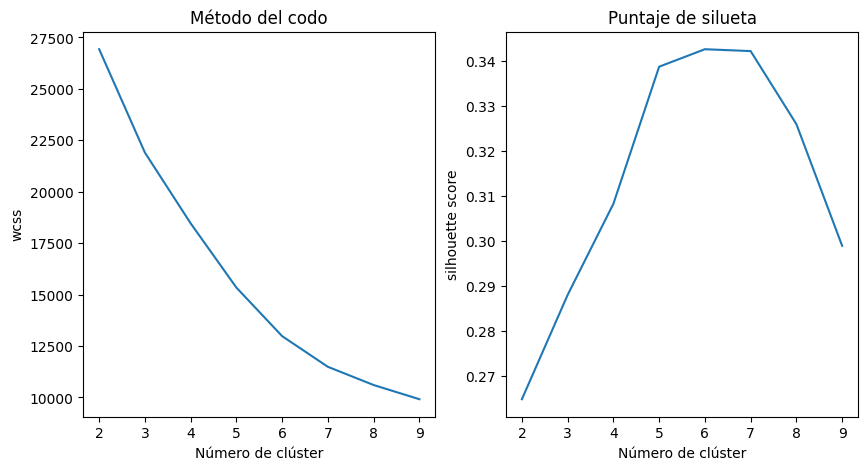

In [ ]:
#K-MEANS
silueta_score=[] # puntaje de silueta
wcss =[] #
n_clusters= range( 2,10)
for k in n_clusters:
  k_means=KMeans(k)
  k_means.fit(scaled_features)
  wcss.append(k_means.inertia_ )
  silueta = silhouette_score(scaled_features, k_means.labels_)
  silueta_score.append(silueta)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(n_clusters,wcss)
axs[0].set_title("Método del codo")
axs[0].set_xlabel("Número de clúster" )
axs[0].set_ylabel("wcss" )
axs[1].plot( n_clusters,silueta_score)
axs[1].set_title("Puntaje de silueta")
axs[1].set_xlabel("Número de clúster" )
axs[1].set_ylabel("silhouette score" )
plt.show()

In [ ]:
k_means=KMeans(5, random_state=123  )
k_means.fit(scaled_features )
datos["labels_k_means"]= k_means.labels_
datos["labels_k_means"] = datos["labels_k_means"].astype(str)
datos["labels_k_means"].value_counts()

,count
labels_k_means,
0,1352
4,1118
2,781
3,753
1,297


Despues de haber realizado el modelo K-Means y luego de observa el metodo del codo y el puntaje silueta se puede concluir que el numero correcto de clusters son 5 ya que el metodo del codo se puede observa que luego del 5 no hubo una caida significativa sino un cambio no tan diferencial lo que hace que el 5 sea un numero potencial de clusters. Y con respecto al puntaje silueta se observa que el pico mas alto lo tuvo el 5 siendo este potencial lo que se concluye que teniendo en cuenta estos dos graficos el correcto numero de clusters es 5

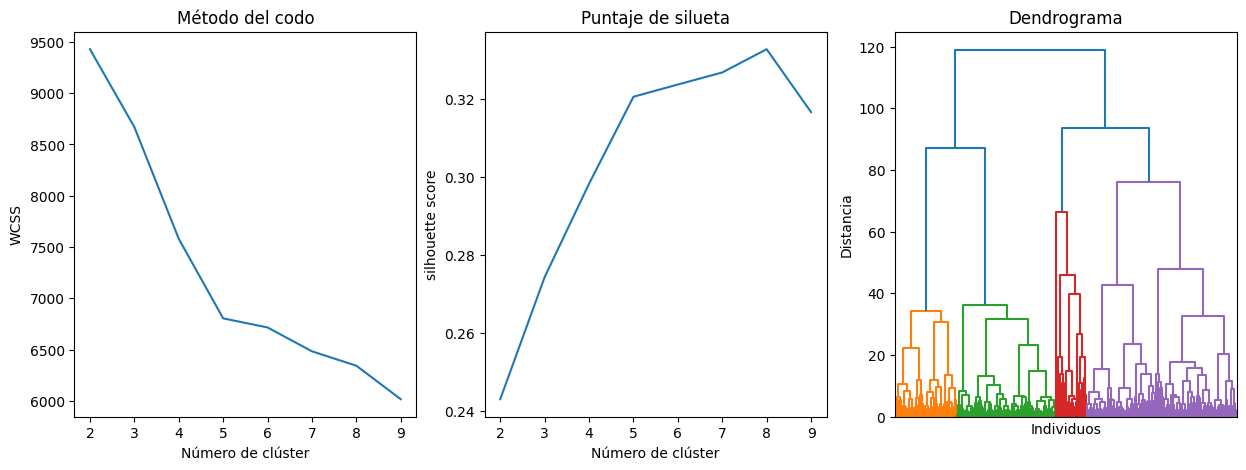

In [ ]:
#Cluster Jerarquico
silueta =[]
wcss =[]
n_cluster=range(2,10)
for i in n_cluster:
  jerarquico = AgglomerativeClustering(i)
  jerarquico.fit(scaled_features)
  scaled_temp= pd.DataFrame(scaled_features)
  scaled_temp["labels"]=jerarquico.labels_
  centros= scaled_temp.groupby("labels").mean()  # obteniendo centros
  argmin, distance =pairwise_distances_argmin_min(scaled_features,centros  )  # obteniendo distancias
  wcss.append(np.sum(distance) )
  score = silhouette_score(scaled_features,jerarquico.labels_ )
  silueta.append(score)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].plot( (n_cluster), wcss  )
axes[0].set_ylabel("WCSS")
axes[0].set_title("Método del codo")
axes[0].set_xlabel("Número de clúster" )
axes[1].plot( (n_cluster), silueta  )
axes[1].set_ylabel("silhouette score")
axes[1].set_title("Puntaje de silueta")
axes[1].set_xlabel("Número de clúster" )

# visualización clustering jerarquico
dist_matrix = linkage(scaled_features, method='ward')
# Visualizar el dendrograma
dendrogram(dist_matrix,no_labels=True)
axes[2].set_title('Dendrograma')
axes[2].set_xlabel('Individuos')
axes[2].set_ylabel('Distancia')
plt.show()

In [ ]:
hc=AgglomerativeClustering(5 )
hc.fit(scaled_features )
datos["labels_hc"]= hc.labels_
datos["labels_hc"] = datos["labels_hc"].astype(str)
datos["labels_hc"].value_counts()

,count
labels_hc,
4,1246
2,1018
1,874
3,784
0,379


Teniendo en cuenta el modelo Cluster jerarquico y sus respectivas graficas se llego a la conclusion que el numero correcto de clusters es 5, esto debido a que en el metodo del codo hasta el 5 fue donde hubo la caida mas pronunciada y despues de este no hubo cambios o caidas significativas, en el puntaje silueta al igual que en el de K-Means el 5 fue donde hubo el pico mas pronunciado dando este cluster como potencial y en el dendograma cuando se realiza el corte para que queden 5 clusters se puede decir que hay una buena distribucion lo que se concluye el correcto numero de clusters es 5

Seleccione un solo algoritmo (K-means o Clúster jerárquico), con el número de clústeres definido en dicho algoritmo. Realice gráficos, resúmenes estadísticos para
cada clúster. De una descripción de cada clúster tanto para los clústeres con el algoritmo seleccionado. Para crear la descripción debe incluir gráficos que involucren
la ubicación, TYPE y seleccione una variable adicional.

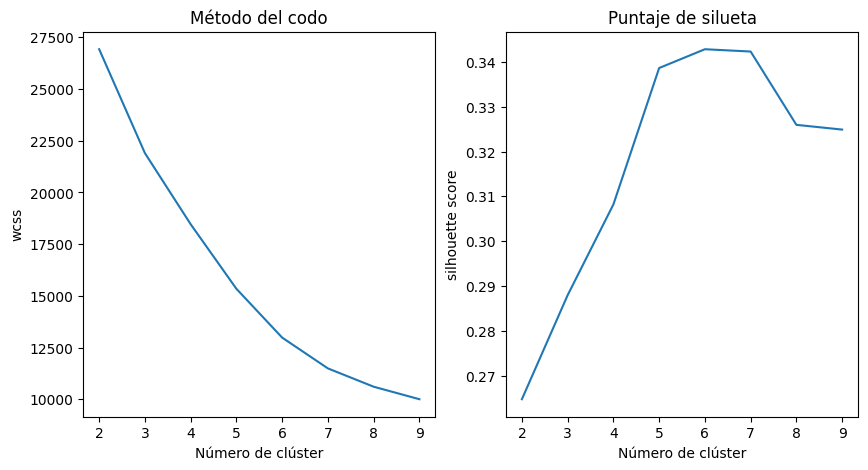

In [ ]:
#MODELO K-MEANS
silueta_score=[] # puntaje de silueta
wcss =[] #
n_clusters= range( 2,10)
for k in n_clusters:
  k_means=KMeans(k)
  k_means.fit(scaled_features)
  wcss.append(k_means.inertia_ )
  silueta = silhouette_score(scaled_features, k_means.labels_)
  silueta_score.append(silueta)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(n_clusters,wcss)
axs[0].set_title("Método del codo")
axs[0].set_xlabel("Número de clúster" )
axs[0].set_ylabel("wcss" )
axs[1].plot( n_clusters,silueta_score)
axs[1].set_title("Puntaje de silueta")
axs[1].set_xlabel("Número de clúster" )
axs[1].set_ylabel("silhouette score" )
plt.show()

In [ ]:
k_means=KMeans(5, random_state=123  )
k_means.fit(scaled_features )
datos["labels_k_means"]= k_means.labels_
datos["labels_k_means"] = datos["labels_k_means"].astype(str)
datos["labels_k_means"].value_counts()

,count
labels_k_means,
0,1352
4,1118
2,781
3,753
1,297


labels_k_means
0    0.314346
4    0.259940
2    0.181586
3    0.175076
1    0.069054
Name: proportion, dtype: float64


<Axes: xlabel='labels_k_means', ylabel='proportion'>

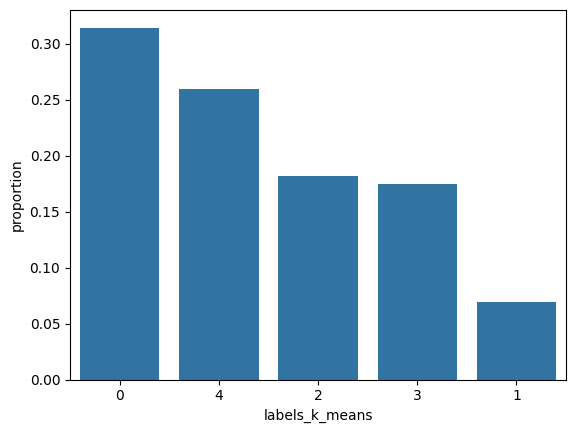

In [ ]:
print(datos["labels_k_means"].value_counts(normalize=True))
sns.barplot(datos["labels_k_means"].value_counts(normalize=True) )

In [ ]:
kmeans = KMeans(n_clusters=5,  random_state=123) # Definir el algoritmo
kmeans.fit(scaled_features)  # Entrenar el modelo
datos["cluster"] = kmeans.labels_ # Obtener las etiquetas
datos["cluster"] = datos["cluster"].astype(str) # Convertir a categoria

fig = px.scatter_mapbox(datos, lat="LATITUDE", lon="LONGITUDE", color="cluster")

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

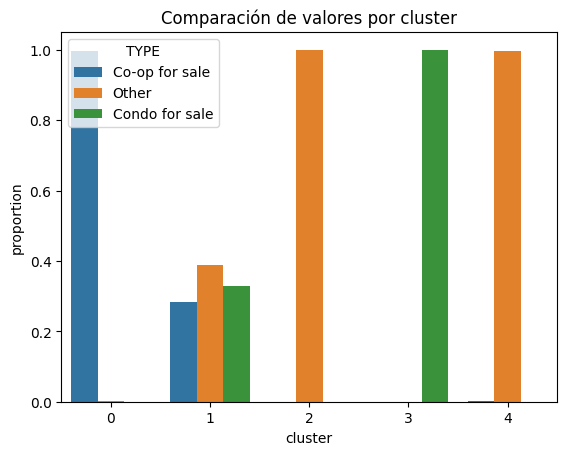

In [ ]:
tabla_frecuencia_relacion= datos.groupby('cluster')['TYPE'].value_counts(normalize=True)
sns.barplot(x='cluster', y='proportion', data=tabla_frecuencia_relacion.reset_index(), hue='TYPE')
plt.title('Comparación de valores por cluster')
plt.show()

In [ ]:
tabla_frecuencia_relacion.reset_index()

,cluster,TYPE,proportion
0,0,Co-op for sale,0.997041
1,0,Other,0.002959
2,1,Other,0.387205
3,1,Condo for sale,0.329966
4,1,Co-op for sale,0.282828
5,2,Other,1.000000
6,3,Condo for sale,1.000000
7,4,Other,0.997317
8,4,Co-op for sale,0.002683


In [ ]:
px.box(datos, x='labels_k_means', y='NumTotalHaYBA',color="labels_k_means",
       points=False, # No muestra los puntos atípicos extendiendo las barras
             title='Numero total de habitaciones y baños: Boxplot por clúster')

**Descripcion cada cluster**
**Cluster 0:**Este cluster tiene una participacion de 31%, en el cual dentro del mapa este cluster posee casas en venta donde no su ubicacion no esta en una parte sino que se encuentran dispersas por Nueva York, entre los cuales el tipo casas que estos tienen a la venta todas son de Co-op for sale y teniendo en cuenta el Box plot la media de estas casas la sumatoria de habitaciones y baños son de 3 lo que se puede ver que no son casas muy grandes las que este cluster vende.
**Cluster 1:**Este cluster tiene una participacion del 6%, el cual teniendo en cuenta el mapa la mayoria de casas que este cluster tiene se encuentra en Manhattan, de las cuales estos poseen casas de diferentes tipos las cuales aproximadamente el 30% son de tipo Co-op for sale, un 35% son Condo for sale y el 40% son de otro tipo y este cluster teniendo en cuenta el box plot la media de estas casas la sumatoria de habitaciones y baños son de 7 lo que se puede decir que poseen casas de buen tamaño.
**Cluster 2:**Este cluster tiene una participacion del 18%, el cual dentro del mapa este cluster posee casas en general tanto en Staten Island como en Brooklyn, ademas en el tipo de casas que estos poseen el 100% de estas son de tipo other y teniendo en cuenta el Box plot la media de estas casas la sumatoria de las habitaciones y los baños la media es de 6 lo que se puede decir que este cluster posee tambien un buen tamaño de casas.
**Cluster 3:**Este cluster tiene una participacion del 17%, el cual dentro del mapa este cluster posee sus casas en tanto en Manhattan, Brooklyn, Staten Island, es decir no tienen una ubicacion estrategica esta regada por todo Nueva York, el tipo de casas que este cluster posee el 100% son de Condo for sale y teniendo en cuenta el Box plot la de media de estas casas que la sumatoria de habitaciones y baños es de 4 lo que tienen casas de tamaño mediano.
**Cluster 4:**Este cluster tiene una participacion del 26%, el cual dentro del mapa el cluster posee estas casas en gran cantidad en el Bronx y en la parte oriental, en los cuales el 100% de estas casas son de tipo Other y teniendo en cuenta el Box plot la media de la sumatoria de las habitaciones y los baños de las casas que este cluster posee la media es de 7 y ademas es el cluster que tiene mayor variabilidad.

De una conclusión general sobre los resultados obtenidos que se relacione con laproblemática y mencione algún tipo de propuesta para un solo clúster del algoritmo
seleccionado.

Despues de haber realizado ambos modelos se puede concluir que tanto el modelo K-Means como el Cluster Jerarquico tuvieron el mismo comportamiento ya que en ambos tuvieron el mismo resultado de clusters lo que hace que ambos tengan el mismo resultado donde una mayor confiabilidad de los metodos. Ademas teniendo en cuenta que el cluster 4 ya que fue el cluster que mas me llamo la atencion porque posee casas mas dispersas y ademas de que poseen casas que los otros clusters no tienen ubicados y de que poseen casas de buen tamaño porque la media de casas en el que la sumatoria de casas y baños son de 7 pero tambien poseen una alta variabilidad por lo que poseen casas tanto mas grandes como mas pequeñas por lo que una propuesta seria tener mas agentes inmobiliriarios para ese cluster ya que estos tienen un publico objetivo muy amplio haciendo que lleguen a mucha gente de diferente ingreso economico.